<a href="https://colab.research.google.com/github/psyuktha/skimlit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


In [15]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [16]:
data_dir='content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [17]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()


In [18]:
train=get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [19]:
#preprocess the data as dictionary with labels and features
def preprocess(filename):
  input=get_lines(filename)
  abstract=''
  abstract_samples=[]
  for i in input:
    if i.startswith("###"):
      astract_id=i
      abstract=''
    elif i.isspace():
      abstract_line_split=abstract.splitlines()
      for line_no,line in enumerate(abstract_line_split):
        line_data={}
        target=line.split("\t")
        line_data['target']=target[0]
        line_data['text']=target[1]
        line_data['line_no']=line_no
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract+=i

  return abstract_samples





In [20]:
train_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')

In [21]:
test_samples=preprocess('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [22]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)


In [23]:
train_sentences=train_df['text'].tolist()
test_sentences=test_df['text'].tolist()


In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

55

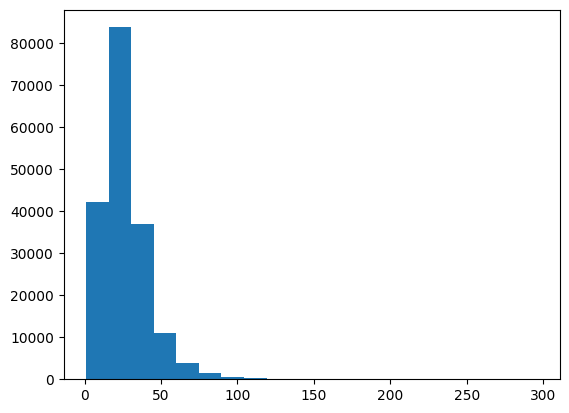

In [25]:
#finding the output sequence length for the vectorisation layer
import matplotlib.pyplot as plt
s=[len(sentence.split()) for sentence in train_sentences]
plt.hist(s,bins=20)
op_len = int(np.percentile(s,95))
op_len

In [26]:
text_vectorizer = TextVectorization( max_tokens = 68000, output_sequence_length=op_len)

In [27]:
text_vectorizer.adapt(train_sentences)

In [33]:
vocab_20 = text_vectorizer.get_vocabulary()
print(f"no of words {len(vocab_20)}")
print(f"common words {vocab_20[:5]}")
print(f"least common words {vocab_20[-5:]}")


no of words 64841
common words ['', '[UNK]', 'the', 'and', 'of']
least common words ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
token_embed = layers.Embedding(input_dim=len(vocab_20),
                                             output_dim=128,
                                             mask_zero= True,
                                             name='token_embedding')

In [35]:
#creating labels
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
one_hot=OneHotEncoder(sparse=False)
train_label_hot=one_hot.fit_transform(tf.expand_dims(train_df['target'],axis=-1))
test_label_hot=one_hot.fit_transform(tf.expand_dims(test_df['target'],axis=-1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
#creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [38]:
num_classes=len(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

In [39]:
inputs=layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x= layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x=layers.Flatten()(x)
#x= layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1= tf.keras.Model(inputs,outputs)

In [40]:
model_1.compile(loss='categorical_crossentropy',
metrics=["accuracy"],
                optimizer=tf.keras.optimizers.Adam()
                )

In [42]:
history_1=model_1.fit(train_dataset,
                      steps_per_epoch=int(0.1*len(train_dataset)),
                                              epochs=3,
                      validation_data=test_dataset,
                      validation_steps = int(0.1*len(test_dataset))
                                              )

Epoch 1/3
562/562 [==============================] - 76s 133ms/step - loss: 0.8187 - accuracy: 0.6752 - val_loss: 0.5991 - val_accuracy: 0.7783
Epoch 2/3
562/562 [==============================] - 75s 134ms/step - loss: 0.5891 - accuracy: 0.7823 - val_loss: 0.5876 - val_accuracy: 0.7773
Epoch 3/3
562/562 [==============================] - 82s 146ms/step - loss: 0.5555 - accuracy: 0.7960 - val_loss: 0.5421 - val_accuracy: 0.7952


In [44]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 7s 8ms/step - loss: 0.5486 - accuracy: 0.7969


[0.548602819442749, 0.7968807220458984]

In [48]:
model_1.save("skimlit")

In [49]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm")

In [50]:
def split_chars(text):
  return ' '.join(list(text))

In [58]:
def visualize_pred_sequence_labels(abstract_dict , model , label_encoder):

  # Setup english sentence parser
  #nlp = English()

  # Construction from subclass
  from spacy.lang.en import English
  nlp = English()

  # Create sentence splitting pipeline object
  #sentencizer = nlp.add_pipe('sentencizer')
  nlp.add_pipe('sentencizer')

  # Create doc of parsed sequences
  doc = nlp(abstract_dict)

  # Return detected sentences from doc in string typpe
  abstract_lines = [str(sent) for sent in list(doc.sents)]

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Loop through each line in the abstract and create a list of dictionaries containing features
  # sample_lines = []
  # for i , line in enumerate(abstract_lines):
  #   sample_dict = {}
  #   sample_dict['text'] = str(line)
  #   sample_dict['line_number'] = i
  #   sample_dict['total_lines'] = total_lines_in_sample - 1
  #   sample_lines.append(sample_dict)


  # Get all line number and total lines numbers then one hot encode them
  # abstract_line_numbers = [line['line_number'] for line in sample_lines]
  # abstract_total_lines = [line['total_lines'] for line in sample_lines]

  # abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers , depth = 15)
  # abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines , depth = 20)


  # # Split the lines into characters
  # abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  # Making prediction on sample features
  abstract_pred_probs = model.predict(x = (
                                           tf.constant(abstract_lines)
                                   ))

  # Turn prediction probs to pred class
  abstract_preds = tf.argmax(abstract_pred_probs , axis = 1)


  classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

  # Prediction class integers into string class name
  abstract_pred_classes = [classes[i] for i in abstract_preds]

  # Prints out the abstract lines and the predicted sequence labels
  for i , line in enumerate(abstract_lines):
    print(f'{abstract_pred_classes[i]}:  {line}\n')




In [56]:
label_encoder = LabelEncoder()
train_label_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
test_label_encoded=label_encoder.fit_transform(test_df["target"].to_numpy())

In [53]:
text_ = "Double-lumen tubes (DLT) and bronchial blockers (BB) are the most commonly used airway tools in thoracic surgery1. They allow isolation of the operative lung from the non-operative lung, which prevents contamination of the non-operative lung by pollutants, such as blood and sputum2. However, in thoracoscopic lobectomy, these two options only protect the non-operative lung from contamination and do not protect the non-operative lobe(s) of the operative lung. Recent case reports have explored the protection of non-operative lobe(s) of the operative lung using solutions such as a DLT + BB or the double-bronchial blocker (DBB) technique3,4,5. These plans are feasible and can provide lung protection for nonsurgical lung lobes. However, given the small sample sizes of these previous reports, the feasibility and efficacy of using DLT + BB or DBB techniques in thoracoscopic lobectomy still need to be determined. Compared with using DLT, using BB showed more infiltrate especially at the surgery side based on the chest X-ray6. Therefore, we hypothesised that a DBB used with continuous positive airway pressure (CPAP) technology might protect the non-operative lobe(s) of the operative lung during thoracoscopic lobectomy.\nThis randomised controlled trial aimed to compare the effects of DBB with CPAP technology and those of routine BB on the non-operative lobe(s) of the operative lung and the incidence of postoperative pneumonia in both the operative and non-operative lung after thoracoscopic lobectomy. "

In [59]:
visualize_pred_sequence_labels(text_, model_1 , label_encoder)

1/1 [==============================] - 0s 186ms/step
BACKGROUND:  Double-lumen tubes (DLT) and bronchial blockers (BB) are the most commonly used airway tools in thoracic surgery1.

BACKGROUND:  They allow isolation of the operative lung from the non-operative lung, which prevents contamination of the non-operative lung by pollutants, such as blood and sputum2.

CONCLUSIONS:  However, in thoracoscopic lobectomy, these two options only protect the non-operative lung from contamination and do not protect the non-operative lobe(s) of the operative lung.

BACKGROUND:  Recent case reports have explored the protection of non-operative lobe(s) of the operative lung using solutions such as a DLT + BB or the double-bronchial blocker (DBB) technique3,4,5.

CONCLUSIONS:  These plans are feasible and can provide lung protection for nonsurgical lung lobes.

BACKGROUND:  However, given the small sample sizes of these previous reports, the feasibility and efficacy of using DLT + BB or DBB techniques 